In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#matplotlib inline

from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

import sys
sys.path.append('./src')

from data_queries import  getClusterInfo, getGAIAKnownMembers
from gaiastars import gaiastars as gs

import astropy.units as u
from astropy.coordinates import SkyCoord, Angle

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


## Great Circle Formulae

from: (https://www.aa.quae.nl/en/reken/grootcirkel.html) See section 4.We'll calculate $\phi = arctan(pmdec, pmra)$ and rotate the result so that 0 points to the south per the article. Note pmra is as reported from the Gaia catalog so that it will contain the $cos(\delta)$ multiplier.

In [2]:
from transforms import cartesian_to_spherical, spherical_to_cartesian

def get_trajectory(gstar, timesample):
    radians_per_mas = 2.0*np.pi/(360*3.6e6)
    # first calculate position after 1 year
    ra1 = np.radians(gstar.ra); dec1=np.radians(gstar.dec)
    #motions in radians per yer
    pmra_cosdec = gstar.pmra*radians_per_mas; pmdec = gstar.pmdec*radians_per_mas
    #Angular separation per year (mu)
    mu = np.sqrt(pmra_cosdec**2 + pmdec**2) # radian per year
    # phi: angular separation at each timesample
    phi = (mu*timesample).reshape(1,-1)
    
    #which direction?
    dir = np.remainder(np.arctan2(pmdec, pmra_cosdec)+2*np.pi, np.pi) #direction from xaxis
    # rotate and flip so that south is 0, west 90, north 180, east 270
    gamma = 3.0*np.pi/2.0 - dir
    
    #south point
    if dec1 >= 0:
        ra_south = ra1
        dec_south = dec1 - np.pi/2.0
    else:
        ra_south = ra1 + np.pi
        dec_south = -np.pi/2 - dec1
    
    #west point
    ra_west = ra1 - np.pi/2
    dec_west = 0.0
    
    #cartesian coords for these points
    radeg = np.degrees(np.array([ra1, ra_south, ra_west]))
    decdeg = np.degrees(np.array([dec1, dec_south, dec_west]))
    dist = np.ones(3) #all on the unit sphere
    xyz = spherical_to_cartesian(radeg, decdeg, dist)
    assert xyz.shape == (3,3)
    #xyz[:,1] is south point; xyz[:,2] is west point
    
    xyz_3 = xyz[:,[1]]* np.cos(gamma) + xyz[:,[2]]*np.sin(gamma)
    assert xyz_3.shape == (3,1)
    
    trajectory_xyz = xyz[:,[0]].dot(np.cos(phi)) + xyz_3.dot(np.sin(phi))
    assert trajectory_xyz.shape == (3, len(timesample))
                                           
    
    #back to spherical coords
    trajectory = cartesian_to_spherical(trajectory_xyz)
    
    return trajectory  
    


In [3]:
radians_per_mas = 2.0*np.pi/(360*3.6e6)
radians_per_mas

4.8481368110953594e-09

In [4]:
(1*u.mas).to(u.radian)

<Quantity 4.84813681e-09 rad>

In [5]:

orion_members = pd.read_csv('./data/OrionMembers.csv', encoding = 'utf8')

# Convert to degrees:
ra_deg = Angle([hms for hms in orion_members.RA], unit="hour")
dec_deg = Angle([d[0:3]+'d'+d[5:7]+'m'+d[9:-1]+'s' for d in orion_members.Dec], unit='degree')

orion_members['RA_deg'] = ra_deg.to_value(u.degree)
orion_members['Dec_deg'] = dec_deg.to_value(u.degree)

dist_pc = (np.array(orion_members.Dist_ly)*u.lightyear).to_value(u.pc)
orion_members['Dist_pc'] = dist_pc
orion_bright = orion_members.query('AppMag <= 4')
offset=-0.5

#from SIMBAD, NGC 1909
witchhead = (Angle("05h 02m 00.00s", unit=u.hour).to_value(u.degree),
              Angle("−07d54m00s", unit=u.degree).to_value(u.degree))


#from Gaia source id search
orion_runaways_gaiaedr3ids = {
    'MuColumbae':2901155648586891648,
    'AeAuriga':182071570715713024
}
id_list = [orion_runaways_gaiaedr3ids[ra] for ra in orion_runaways_gaiaedr3ids]
orion_runaways = gs(name = 'Orion Runaways')
orion_runaways.from_source_idlist(id_list)

#stuff in radial velocities from SIMBAD, Gaia doesn't have these
orion_runaways.objs['radial_velocity'] = [109.00, 56.70]

#ONC mmotions frmo Farias et al 2020
ONC = pd.Series({'ra':Angle('05h35m0.0s', unit=u.hour).to_value(u.degree),
                    'dec':Angle('-05d29m0.0s', unit=u.degree).to_value(u.degree), 'parallax': 2.48, 'r_est':403,
                    'pmra':1.43, 'pmra_error':0.14, 'pmdec':0.52, 'pmdec_error':0.12,
                    'radial_velocity':26.4, 'radial_velocity_error':1.6})

INFO: Query finished. [astroquery.utils.tap.core]


In [6]:
dt = np.arange(-200e6,0,100000)

In [7]:
traj = get_trajectory(orion_runaways.objs.iloc[0], dt)

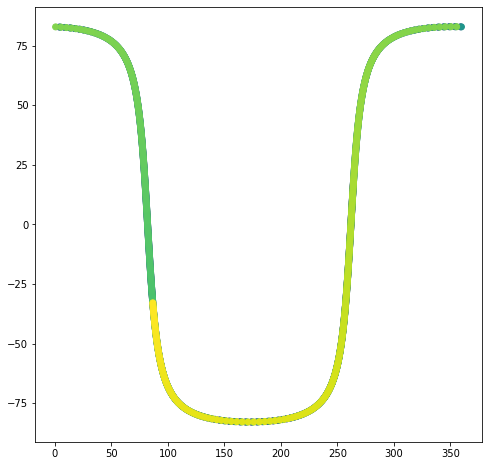

In [8]:
fig = plt.figure(figsize=(8,8))
ax = fig.subplots(1,1)
ax.scatter(traj['alpha'], traj['delta'], c=dt)

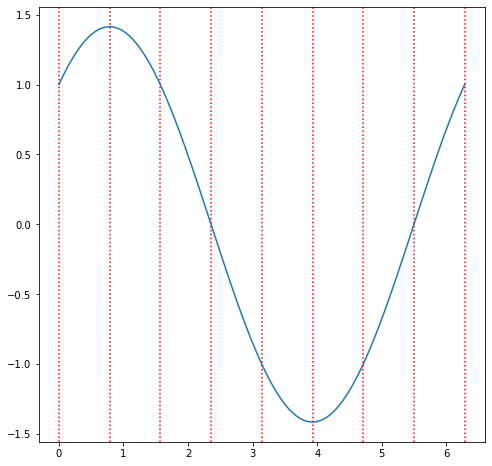

In [9]:
rad = np.linspace(0,2*np.pi,3600)
y = np.cos(rad)+np.sin(rad)
fig = plt.figure(figsize=(8,8))
ax = fig.subplots(1,1)
ax.plot(rad,y)
for theta in np.arange(0,2*np.pi+np.pi/4,np.pi/4):
    ax.axvline(theta, color='red',ls=':')

In [10]:
(np.pi*np.arange(0,2*np.pi,np.pi/4)).tolist()

[0.0,
 2.4674011002723395,
 4.934802200544679,
 7.4022033008170185,
 9.869604401089358,
 12.337005501361697,
 14.804406601634037,
 17.271807701906376]

In [11]:
traj['delta'].min(), traj['delta'].max()

(-82.91508440677985, 82.91404584156619)

## Vector Implementation

In [12]:
# calculate mu and phi (Smart p252)
def get_mu_phi(gstar):
    tan_phi = gstar.pmra/gstar.pmdec
    phi = np.arctan(tan_phi) # worry about quadrant?
    mu = gstar.pmra/np.sin(phi)
    assert np.allclose(mu, gstar.pmdec/np.cos(phi))
    
    return mu, phi

In [13]:
get_mu_phi(orion_runaways.objs.iloc[0])

(-22.416119859731772, -0.1464289307831943)

In [15]:
# get a point along the trajectory that's 90 deg east

def traj90(gstar):
    mu, phi = get_mu_phi(gstar)
    rarad = np.radians(gstar.ra); decrad = np.radians(gstar.dec)
    side_b = colat = np.pi/2 - decrad # colatitude (does this work for southern hemisphere?)
    
    #calc colat of point 90 degrees away;
    angle_A = phi
    angle_B = np.arccos(np.cos(side_b)*np.sin(angle_A)) # see GRC book P238 Spherical Geometry section
    side_a = np.arcsin(np.tan(side_b)/np.tan(angle_B)) # colatitude of pt 90 deg east
    
    print(f'Angle A: {phi}, Angle B: {angle_B}, side a: {side_a}')
    ra = np.degrees(rarad+np.pi/2)
    dec = np.degrees(np.pi/2 - side_a)
    
    return ra, dec 
    


In [28]:
b = np.pi/2 - np.radians(orion_runaways.objs.iloc[0].dec)
B = np.arccos(np.cos(b)*np.sin(-0.1464289307831943))
print(f'Angle B: {B}, side b: {b}, side b (degrees){np.degrees(b)}')

Angle B: 1.4927376897777835, side b: 2.134651689217639, side b (degrees)122.30653252264257


In [27]:
np.tan(b),np.tan(B)

(-1.58144434852915, 12.78485203371054)

In [16]:
P1 = np.array([np.sqrt(2)/2]*2)
np.linalg.norm(P1)

1.0

In [18]:
traj90(orion_runaways.objs.iloc[0])

Angle A: -0.1464289307831943, Angle B: 1.4927376897777835, side a: -0.12401436350005217


(176.4995797980886, 97.10549962755422)

In [21]:
(orion_runaways.objs.iloc[0])

source_id           2.901156e+18
ra                  8.649958e+01
dec                -3.230653e+01
parallax            1.702442e+00
pmra                3.270651e+00
pmdec              -2.217623e+01
radial_velocity     1.090000e+02
phot_g_mean_mag     5.106183e+00
phot_bp_mean_mag    4.963513e+00
phot_rp_mean_mag    5.381521e+00
ruwe                1.245298e+00
r_est               5.873914e+02
Name: 2901155648586891648, dtype: float64

In [18]:
i = np.array([1,0,0])
j = np.array([0,1,0])
k = np.array([0,0,1])

In [19]:
np.cross(j,k)

array([1, 0, 0])

In [20]:
def basis(P1, P2):
    #compute P3 orthoganol ot P1, P2
    P3 = np.cross(P1, P2)
    #P4 orthoganal to P1, P3
    P4 = np.cross(P1, P3)
    #P1 is new x axis, P4 new y axis and P3 new z axis
    b = np.array([P1, P4, P3])
    norms = np.linalg.norm(b, axis=1)
    b = b/norms
    #transpose result into 3 column vectors
    return b.T

In [90]:
dt = 1000 # years (scalar to avoid numerical precision problems)
#r = 1 #pc, => unit sphere
r=ONC.r_est
degree_per_mas = (1*u.mas).to_value(u.degree)
onc = spherical_to_cartesian(ONC.ra, ONC.dec, r)
onc_prime = spherical_to_cartesian(ONC.ra +(dt*ONC.pmra/np.cos(np.radians(ONC.dec)))*degree_per_mas,
                                  ONC.dec + dt*ONC.pmdec*degree_per_mas, r)

In [78]:
onc_basis = basis(onc, onc_prime)

In [81]:
onc_basis

array([[ 1.08368704e-01,  6.86540485e-06,  2.57816634e-06],
       [ 1.34134524e+05, -1.34773928e-01,  5.20648794e-02],
       [-1.29532969e+04, -3.40178912e-01,  9.35493090e-01]])

In [91]:
onc_coord = SkyCoord(ra=ONC.ra*u.degree, dec=ONC.dec*u.degree,
                    pm_ra_cosdec = ONC.pmra*u.mas/u.year,
                    pm_dec = ONC.pmdec*u.mas/u.year,
                    distance = ONC.r_est*u.pc, radial_velocity = ONC.radial_velocity*u.km/u.second)

In [93]:
onc_prime, onc_coord.apply_space_motion(dt=1000*u.year).cartesian.xyz.value

(array([ 43.66982096, 398.77195252, -38.50813705]),
 array([ 43.67274675, 398.79866765, -38.51071692]))

### From Intro to Astrophysics (p 16 ff)

In [115]:
def pos_t(ra, dec, pmra_cosdec, pmdec, t):
    degree_per_mas = (1*u.mas).to_value(u.degree)
    ra_rad = np.radians(ra); dec_rad = np.radians(dec)
    #motions in radians/year
    pmra_cosdec_rad = np.radians(pmra_cosdec*degree_per_mas); pmdec_rad=np.radians(degree_per_mas*pmdec)
    #change in ra in one year in radians
    pmra_rad = pmra_cosdec_rad/np.cos(dec_rad)
    
    #approximate mu (radians per year)
    mu = np.sqrt(pmra_cosdec_rad**2 + pmdec_rad**2)
    
    #calculate position angle phi (see p18, equation above eq 1.6)
    sin_phi = np.sin(pmra_rad)*np.cos(dec_rad+pmdec_rad)/np.sin(mu)
    phi = np.pi - np.arcsin(sin_phi)
    
    delta_mu = mu*t
    
    delta_ra_rad = delta_mu*np.sin(phi)/np.cos(dec_rad)
    ra_rad_t = ra_rad+delta_ra_rad
    
    delta_dec_rad = delta_mu*np.cos(phi)
    dec_rad_t = dec_rad + delta_dec_rad
    
    return np.degrees(ra_rad_t), np.degrees(dec_rad_t)

In [116]:
t = np.arange(0,1e5, 1000)

In [117]:
onc_ra_t, onc_dec_t = pos_t(ONC.ra, ONC.dec, ONC.pmra, ONC.pmdec, t)

In [113]:
onc_t = onc_coord.apply_space_motion(dt=t)

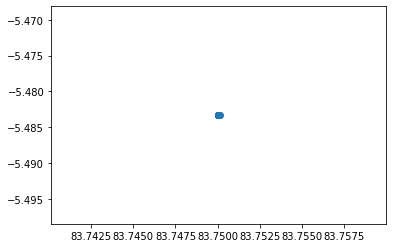

In [118]:
plt.scatter(onc_t.ra, onc_t.dec)

## Known Members from Kun et. al. (2004)

In [The IC 2118 association: new T Tauri stars in high-latitude molecular clouds](https://arxiv.org/pdf/astro-ph/0402353.pdf) Kun, et. al. (2004) provide lists of H-alpha emitting stars and pre-main sequence stars - presumably(?) stars associated with IC2118.

From Table 3 in the paper, their 2MASS id's are:
'05020630-0850467',
'05065349-0617123',
'05071157-0615098',
'05073016-0610158',
'05073060-0610597'


In [7]:
from astroquery.gaia import Gaia

#don't run this code

in_interest_of_time = """
#member list from Kun et al 2004
mass2_list=['05020630-0850467',
'05065349-0617123',
'05071157-0615098',
'05073016-0610158',
'05073060-0610597']

#need quotes on the ids
mass2_list_q = [f'\'{m2}\'' for m2 in mass2_list]

#get the gaiaedr3 source_ids from the cross match table
qry_str = 'select * from gaiaedr3.tmass_psc_xsc_best_neighbour where original_ext_source_id in ('+\
        ','.join(mass2_list_q) + ')'

job = Gaia.launch_job_async(query=qry_str)
df = job.get_results().to_pandas()
df_nearest = df.sort_values(['original_ext_source_id','angular_distance']).\
            groupby('original_ext_source_id', as_index=False).first()
            
ic2118_members_source_ids = df_nearest.source_id.to_list()
"""

#code above produces this list:
ic2118_members_source_ids = \
    [3183583970597624576,
     3211220985635712384,
     3211222944140793984,
     3211247202116818944,
     3211223665694190848]

ic2118_members = gs(name = 'IC2119 Members', description = 'IC2119 Membership list from Kun, et al *2004')
ic2118_members.from_source_idlist(list(ic2118_members_source_ids))

INFO: Query finished. [astroquery.utils.tap.core]


In [8]:
in_interest_of_time = """
spitzer_2mass_id_list = ['05065009–0619079',
 '05065349-0617123',
 '05071157-0615098',
 '05072058-0616119',
 '05072188-0611524',
 '05072865-0613258',
 '05072937-0616368',
 '05073016-0610158',
 '05073060-0610597',
 '05073372-0613474']

#need quotes on the ids
mass2_list_q = [f'\'{m2}\'' for m2 in spitzer_2mass_id_list]

#get the gaiaedr3 source_ids from the cross match table
qry_str = 'select * from gaiaedr3.tmass_psc_xsc_best_neighbour where original_ext_source_id in ('+\
        ','.join(mass2_list_q) + ')'

job = Gaia.launch_job_async(query=qry_str)
df = job.get_results().to_pandas()
df_nearest = df.sort_values(['original_ext_source_id','angular_distance']).\
            groupby('original_ext_source_id', as_index=False).first()
            
spitzer_source_ids = df_nearest.source_id.to_list()
"""
spitzer_source_ids = [
     3211220985635712384,
     3211222944140793984,
     3211219748685124352,
     3211223596975818112,
     3211223253378434560,
     3211219576886431744,
     3211247202116818944,
     3211223665694190848,
     3211220401520148992]
    

spitzer_members = gs(name='IC2118 Members from Spitzer', description = 'IC2118 membership list from Guieu et al. 2010')
spitzer_members.from_source_idlist(spitzer_source_ids)

INFO: Query finished. [astroquery.utils.tap.core]


In [9]:
spitzer_members.objs

,source_id,ra,dec,parallax,pmra,pmdec,radial_velocity,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,ruwe,r_est
typed_id,,,,,,,,,,,,
3211220985635712384,3211220985635712384,76.722834,-6.286812,2.495389,1.385348,-4.886892,NaN,15.385917,16.862177,13.724136,25.658398,400.739190
3211222944140793984,3211222944140793984,76.798217,-6.252759,3.333479,0.704681,-3.877738,NaN,15.624154,17.001530,14.374179,1.016798,299.986856
3211219748685124352,3211219748685124352,76.835767,-6.270008,3.375574,0.745687,-3.350524,NaN,17.002775,19.511156,15.547362,1.044222,296.245940
3211223596975818112,3211223596975818112,76.841210,-6.197937,NaN,NaN,NaN,NaN,19.904470,19.958673,17.420464,NaN,NaN
3211223253378434560,3211223253378434560,76.869411,-6.223878,3.483348,0.591594,-3.481526,NaN,16.345694,18.474447,14.928147,1.039588,287.080118
3211219576886431744,3211219576886431744,76.872396,-6.276949,3.565777,0.950442,-3.983873,NaN,17.970516,19.485188,16.612976,1.192471,280.443774
3211247202116818944,3211247202116818944,76.875703,-6.171124,3.404015,0.615872,-3.205192,NaN,15.240180,16.530535,13.758308,19.963552,293.770767
3211223665694190848,3211223665694190848,76.877447,-6.183333,3.446275,-0.353197,-2.553458,NaN,14.456684,14.913568,12.356484,1.628415,290.168402
3211220401520148992,3211220401520148992,76.890504,-6.229878,3.493182,0.945956,-3.438799,NaN,16.913092,19.141979,15.503268,1.030535,286.271929


In [6]:
set(spitzer_source_ids) - set(ic2118_members_source_ids)

{3211219576886431744,
 3211219748685124352,
 3211220401520148992,
 3211223253378434560,
 3211223596975818112}

In [7]:
set(ic2118_members_source_ids) - set(spitzer_source_ids)

{3183583970597624576}

In [8]:
#plt.style.use('dark_background')

plt.style.use('default')
from matplotlib.patches import Circle

## Cone Search Parameters

In [9]:
cone_search_center=(77.0, -8.0); search_radius=7.5 #degree
#Kun et al (2001) distance: 210 pc +/- 20pc
#keep distance between 100 and 300 pc
dist_constraint=(100,300) #pc
plx_hi = 1000.0/dist_constraint[0]
plx_lo = 1000.0/dist_constraint[1]
(plx_lo, plx_hi)

(3.3333333333333335, 10.0)

## Cone Search

In [10]:
kounkel_constraints = [
    '{schema}.gaia_source.parallax_over_error > 10',
    '1.0857/{schema}.gaia_source.phot_g_mean_flux_over_error < 0.03',
    '{schema}.gaia_source.astrometric_sigma5d_max < 0.3',
    '{schema}.gaia_source.visibility_periods_used > 8',
    '(({schema}.gaia_source.astrometric_excess_noise < 1) or (({schema}.gaia_source.astrometric_excess_noise> 1) and ({schema}.gaia_source.astrometric_excess_noise_sig <2)))']

In [11]:
# search with the gaia paper (default) search constraints
cons = ['{schema}.gaia_source.source_id is not NULL']
search_results1=gs(name="conesearch near witch head nebula, no constraints")
search_results1.set_gaia_source_constraints(cons)
search_results1.conesearch(cone_search_center[0]*u.degree, cone_search_center[1]*u.degree,search_radius*u.degree, parallax=(plx_lo, plx_hi))

# get rid of all constraints
search_results=gs(name="conesearch near witch head nebula, kounkel constraints")
search_results.set_gaia_source_constraints(kounkel_constraints)

search_results.conesearch(cone_search_center[0]*u.degree, cone_search_center[1]*u.degree,search_radius*u.degree, parallax=(plx_lo, plx_hi))
print(f'Unonstrained Search: {len(search_results1)} objects, With Kounkel Constraints: {len(search_results)} objects')

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
Unonstrained Search: 34838 objects, With Kounkel Constraints: 19039 objects


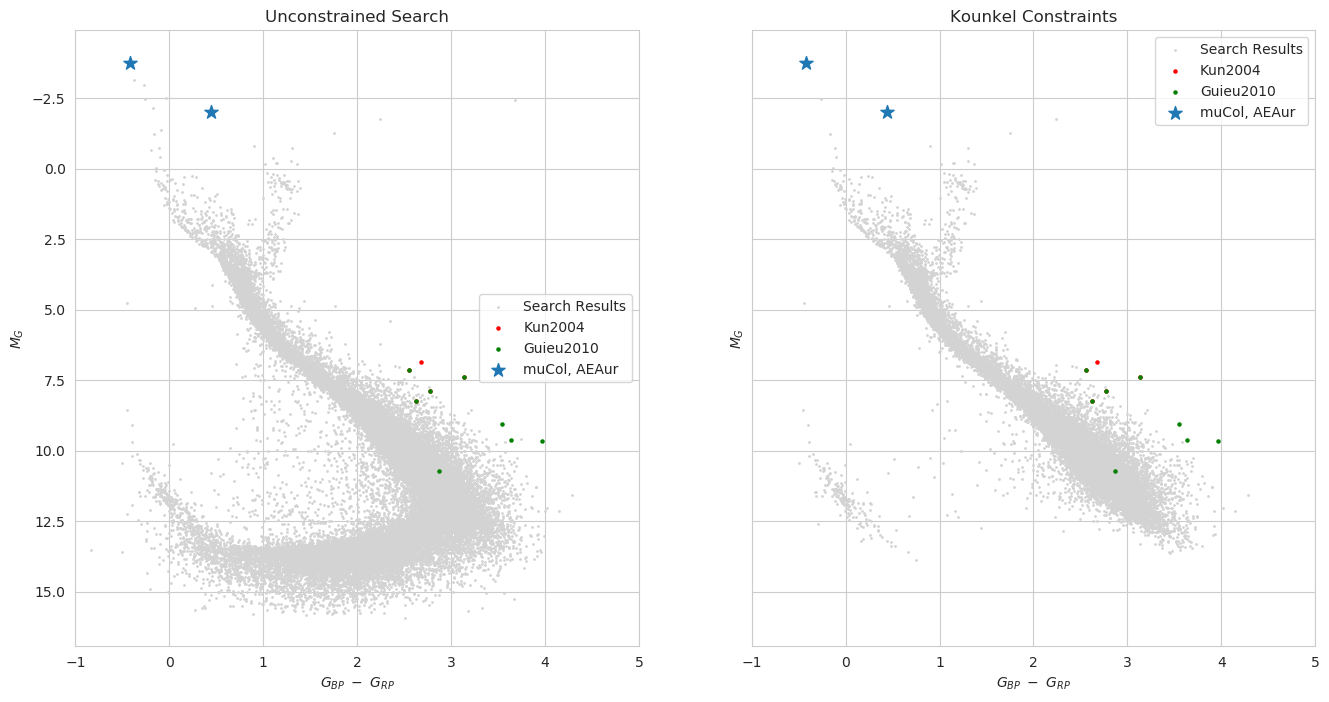

In [84]:
fig = plt.figure(figsize=(16,8))
ax = fig.subplots(1,2,sharey=True)
search_results1.plot_hrdiagram(ax=ax[0], s=1, color='lightgrey', label='Search Results')
ic2118_members.plot_hrdiagram(ax=ax[0], s=5, color='red',  label='Kun2004')
spitzer_members.plot_hrdiagram(ax=ax[0], s=5, color='green', label='Guieu2010')
orion_runaways.plot_hrdiagram(ax=ax[0], s=100, marker='*', label='muCol, AEAur')
ax[0].set_title('Unconstrained Search')
ax[0].legend()

search_results.plot_hrdiagram(ax=ax[1], s=1, color='lightgrey', label='Search Results')
ic2118_members.plot_hrdiagram(ax=ax[1], s=5, color='red', label='Kun2004')
spitzer_members.plot_hrdiagram(ax=ax[1], s=5, color='green', label='Guieu2010')
orion_runaways.plot_hrdiagram(ax=ax[1], s=100, marker='*', label='muCol, AEAur')
ax[1].set_title('Kounkel Constraints')
ax[1].legend()


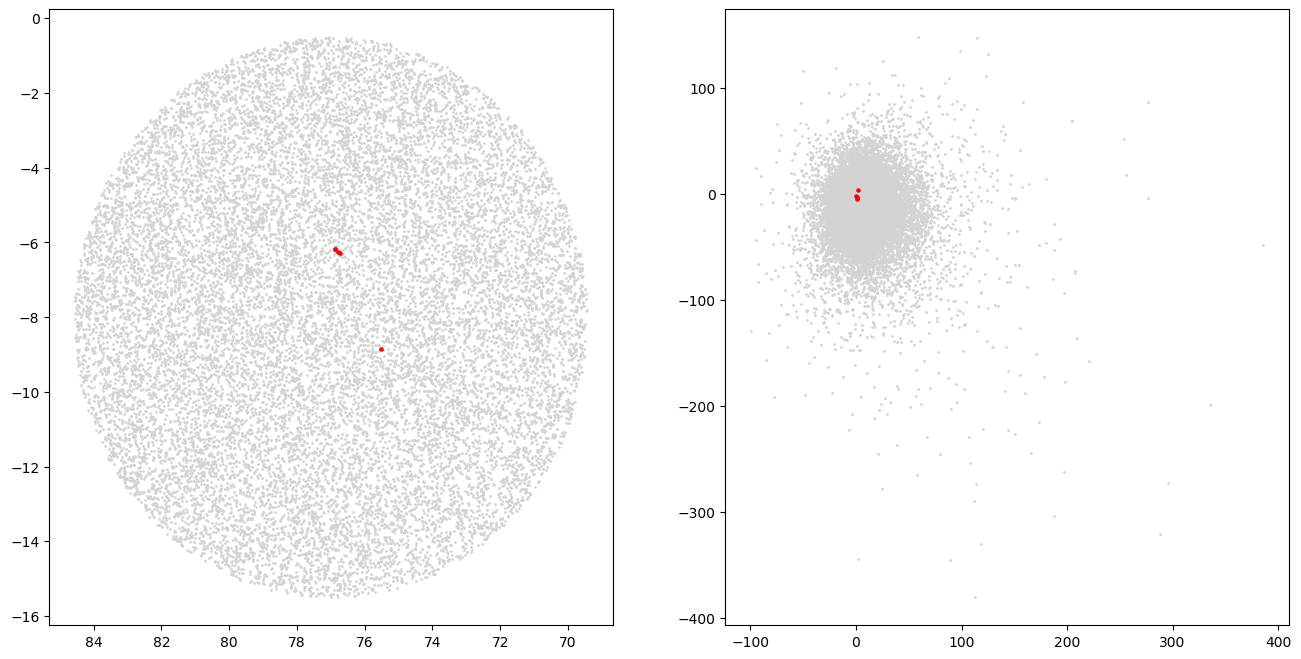

In [13]:
fig = plt.figure(figsize=(16,8))
axs = fig.subplots(1,2)
axs[0].scatter(search_results.objs.ra, search_results.objs.dec, s=1, color='lightgrey')
axs[0].scatter(ic2118_members.objs.ra, ic2118_members.objs.dec, s=5, color='red')
#axs[0].scatter(spitzer_members.objs.ra, spitzer_members.objs.dec, s=5, color='green')
axs[0].invert_xaxis()

axs[1].scatter(search_results.objs.pmra, search_results.objs.pmdec, s=1, color='lightgrey')
axs[1].scatter(ic2118_members.objs.pmra, ic2118_members.objs.pmdec, s=5, color='red')
#axs[1].scatter(spitzer_members.objs.pmra, spitzer_members.objs.pmdec, s=5, color='green')

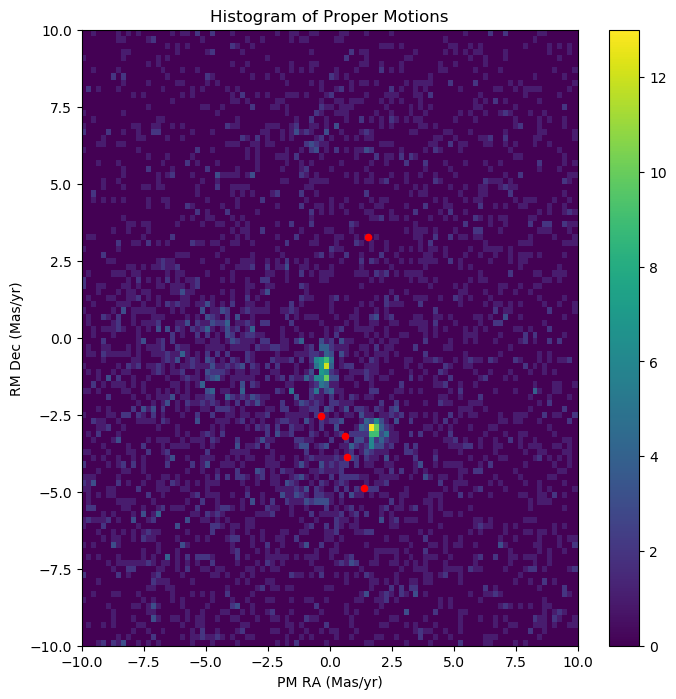

In [14]:
fig = plt.figure(figsize=(8,8))
ax = fig.subplots(1,1)
zz=ax.hist2d(search_results.objs.pmra, search_results.objs.pmdec,bins=100,
            range = [(-10,10),(-10,10)])
ax.scatter(ic2118_members.objs.pmra, ic2118_members.objs.pmdec, s=20, color='red')

ax.set_xlabel('PM RA (Mas/yr)')
ax.set_ylabel('RM Dec (Mas/yr)')
ax.set_title('Histogram of Proper Motions')
fig.colorbar(zz[3])
#ax.set_xlim(-20,20)
#ax.set_ylim(-20,20)

## Just Results with Radial Velocity (for now)

In [15]:
print(f"Search Results with RV: {np.isfinite(search_results.objs.radial_velocity).sum()}, total stars: {len(search_results)}")

Search Results with RV: 3239, total stars: 19039


In [16]:
search_results.objs['hasRV'] = np.isfinite(search_results.objs.radial_velocity)

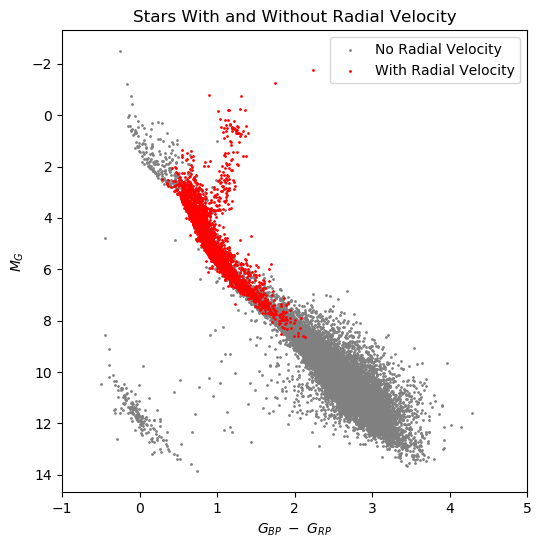

In [17]:
fig = plt.figure(figsize=(6,6))
ax=fig.add_subplot()

search_results.query('~hasRV').plot_hrdiagram(ax=ax, label='No Radial Velocity', color='grey')
search_results.query('hasRV').plot_hrdiagram(ax=ax, label='With Radial Velocity', color='red')

ax.set_title('Stars With and Without Radial Velocity')
ax.legend()

In [18]:
search_results_rv = search_results.query('hasRV')

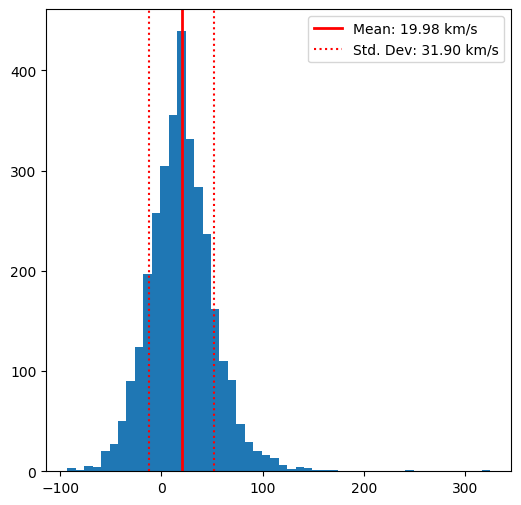

In [19]:
rv_mean = search_results_rv.objs.radial_velocity.mean()
rv_sd = search_results_rv.objs.radial_velocity.std()
fig = plt.figure(figsize=(6,6))
ax=fig.add_subplot()
ax.hist(search_results_rv.objs.radial_velocity, bins=50)
ax.axvline(rv_mean, lw=2, label=f'Mean: {rv_mean:.2f} km/s', color='red')
ax.axvline(rv_mean-rv_sd, ls=':', label=f'Std. Dev: {rv_sd:.2f} km/s', color='red')
ax.axvline(rv_mean+rv_sd, ls=':', color='red')
ax.legend()

In [20]:
from transforms import pm_to_dxyz, spherical_to_cartesian, cartesian_to_spherical

In [21]:
#cartesian motion in km/s in galactic LSR
from astropy.coordinates import GalacticLSR
coords_rv = search_results_rv.get_coords(default_rv=True).transform_to(GalacticLSR)
search_results_rv_dxyz = coords_rv.velocity.d_xyz.value

In [22]:
velocities = np.sqrt((search_results_rv_dxyz**2).sum(axis=0))

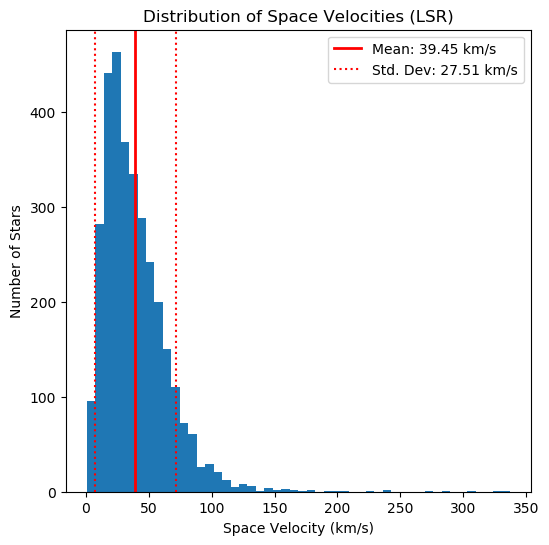

In [23]:
vel_mean = velocities.mean()
vel_sd = velocities.std()
fig = plt.figure(figsize=(6,6))
ax=fig.add_subplot()
ax.hist(velocities, bins=50)
ax.axvline(vel_mean, lw=2, label=f'Mean: {vel_mean:.2f} km/s', color='red')
ax.axvline(vel_mean-rv_sd, ls=':', label=f'Std. Dev: {vel_sd:.2f} km/s', color='red')
ax.axvline(vel_mean+rv_sd, ls=':', color='red')

ax.set_title('Distribution of Space Velocities (LSR)')
ax.set_xlabel('Space Velocity (km/s)')
ax.set_ylabel('Number of Stars')

ax.legend()

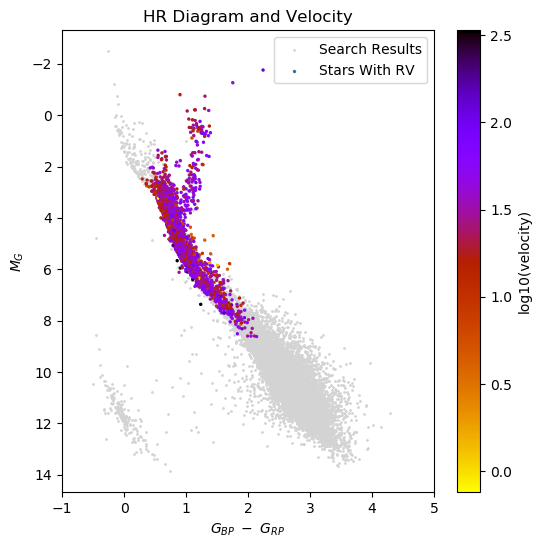

In [24]:
fig = plt.figure(figsize=(6,6))
ax=fig.add_subplot()
search_results.plot_hrdiagram(ax=ax, s=1, color='lightgrey', label='Search Results')
pcm = search_results_rv.plot_hrdiagram(ax=ax, c=np.log10(velocities), s=2, label='Stars With RV', cmap='gnuplot_r')

ax.set_title('HR Diagram and Velocity')


ax.legend()
fig.colorbar(pcm, label='log10(velocity)')

## Compute Positions 2.5M Years Ago

In [25]:
def pos_lbt(xyz, d_xyz, lbt):
    # xyz in pc, d_xyz in km/s, lbt in years (signed)
    #conversion factors
    degree_per_mas = 1/(1000*60*60)
    seconds_per_year = (1.0*u.year).to_value(u.second)
    pc_per_km = (1.0*u.km).to_value(u.pc)
    assert xyz.shape == d_xyz.shape
    
    return xyz +(d_xyz*lbt*seconds_per_year)*pc_per_km

From Kun et al on IC2118 clouds:
> The radial velocities of the
clouds, however, are more negative $(−5.30 < v_{LSR} <
+4.8 km s^{−1})$

In [26]:
#use of rv=16.0 below results in rv_lsr approx=-1.0, close to the midpoint of Kun's range
ic2118_coords = ic2118_members.get_coords(recalc=True, default_rv=16.0).transform_to(GalacticLSR)
ic2118_coords.radial_velocity

<Quantity [-1.15782641, -1.00540475, -1.00616331, -1.00261537, -1.00382917] km / s>


2001 apj v547 p792 
dame, hartmann, thaddeus,p
milky way and molecular clouds a new complete co survey

spitzer observation of IC2118, S Guieu et al.

In [27]:
look_back_time = -2.5*10e6 # years, negative for look BACK time

ic2118_xyz = ic2118_coords.cartesian.xyz.to_value()
ic2118_dxyz = ic2118_coords.velocity.d_xyz.to_value()
ic2118_lbt_xyz = pos_lbt(ic2118_xyz, ic2118_dxyz, look_back_time)
ic2118_lbt_spherical = cartesian_to_spherical(ic2118_lbt_xyz)

search_results_rv_xyz = coords_rv.cartesian.xyz.value # pc
search_results_rv_dxyz = coords_rv.velocity.d_xyz.value #km/s
search_results_lbt_xyz = pos_lbt(search_results_rv_xyz, search_results_rv_dxyz, look_back_time)
search_results_lbt_spherical = cartesian_to_spherical(search_results_lbt_xyz)


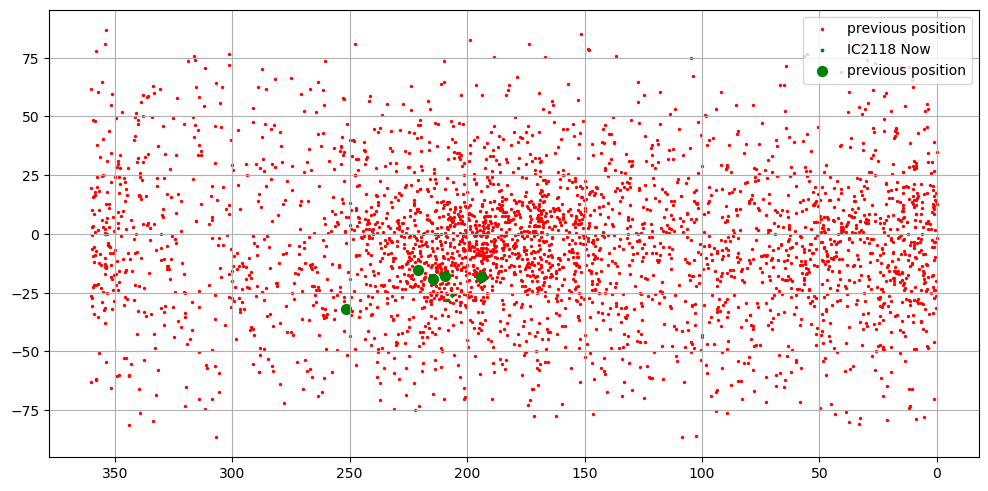

In [28]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot()

#ax.scatter(coords_rv.l, coords_rv.b, s=1, label='Search Results', color='black')

ax.scatter(search_results_lbt_spherical['alpha'],
          search_results_lbt_spherical['delta'], color='red',label='previous position',s=2)

ax.scatter(ic2118_coords.l, ic2118_coords.b, s=3, label='IC2118 Now', color='Green')
ax.scatter(ic2118_lbt_spherical['alpha'],
           ic2118_lbt_spherical['delta'], color='green',label='previous position',s=50)

ax.invert_xaxis()
ax.grid(); ax.legend()
ax.set_aspect('equal')



## DBSCAN to identify Clusters at Lookback time

In [29]:
from scipy.stats import zscore
from sklearn.cluster import DBSCAN

In [30]:
# standardize the lbt positions
search_results_lbt_std = zscore(search_results_lbt_xyz, axis=1,ddof=1)

In [31]:
clusters = DBSCAN(eps=0.1, min_samples=10).fit(search_results_lbt_std.T)

In [32]:
labels, counts = np.unique(clusters.labels_,return_counts=True)

In [33]:
labels

array([-1,  0,  1,  2,  3,  4,  5,  6])

In [34]:
counts

array([3100,   24,   40,   11,   24,   18,   10,   12])

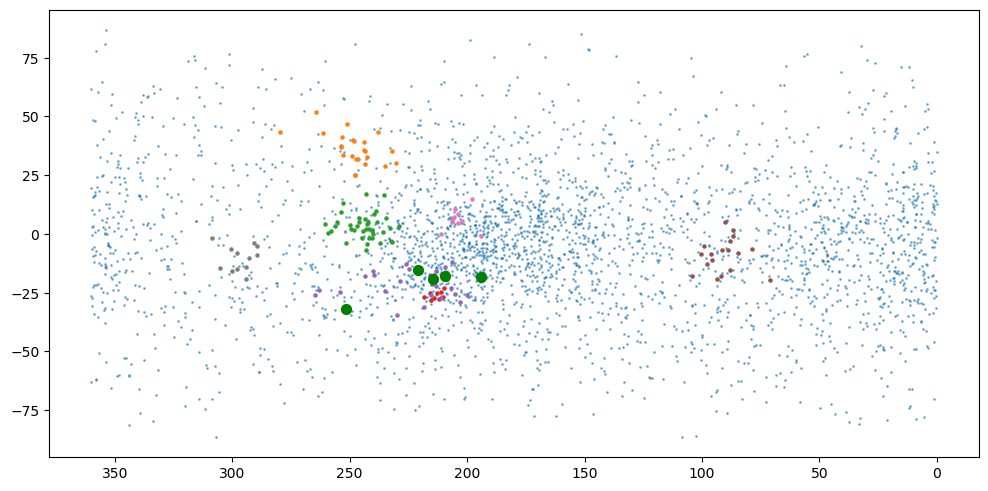

In [35]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot()

#ax.scatter(coords_rv.l, coords_rv.b, s=1, label='Search Results', color='black')

for cl in range(-1,clusters.labels_.max()+1):
    if cl==-1:
        a=0.5
        sz = 1
    else:
        a=1.0
        sz=5
    mask = clusters.labels_ == cl
    ax.scatter(search_results_lbt_spherical['alpha'][mask],
          search_results_lbt_spherical['delta'][mask], label='previous position',alpha=a, s=sz)


ax.scatter(ic2118_lbt_spherical['alpha'],
           ic2118_lbt_spherical['delta'], color='green',label='previous position',s=50)

ax.invert_xaxis()
#ax.grid(); ax.legend()
ax.set_aspect('equal')

## Identify Moving Groups

### Projection of Motion onto Line of Sight

<div>
<img  src="images/Projection.jpg" alt="projection" title="project onto LOS" width="600"/>
</div>


In [36]:
#zoom ranges for tangental velocity plots
tv_zoom = [(-25, 25),(-25,25)]

In [37]:
# conesearch in galactic coords:
search_center = SkyCoord(ra=cone_search_center[0]*u.deg, dec=cone_search_center[1]*u.deg).galactic
search_center

<SkyCoord (Galactic): (l, b) in deg
    (208.24316783, -26.60678598)>

In [38]:
from astropy.coordinates import GalacticLSR
def pm_to_tangv(gstar, center, default_rv = 0.0):
    #remove Sun's peculiar motion:
    coords = gstar.get_coords(recalc=True, default_rv = default_rv).transform_to(GalacticLSR)

    #how far the indiv stars are from the search center in radian
    delta_l_rad = coords.l.radian - center.l.radian
    delta_b_rad = coords.b.radian - center.b.radian

    #project motions onto search center LOS in radians/year
    proj_pm_l_cosb = (coords.pm_l_cosb*np.sin((np.pi/2) - delta_l_rad)).to(u.radian/u.year)
    proj_pm_b = (coords.pm_b*np.sin((np.pi/2) - delta_b_rad)).to(u.radian/u.year)

    #scale the motion by distance (result in pc/year), then to km/s
    tang_v_l = (proj_pm_l_cosb/(1*u.radian)*coords.distance).to(u.km/u.second)
    tang_v_b = (proj_pm_b/(1*u.radian)*coords.distance).to(u.km/u.second)
    
    pos = coords.cartesian.xyz
    
    return tang_v_l, tang_v_b, pos


In [39]:
sr_vl, sr_vb, sr_pos = pm_to_tangv(search_results, search_center, 0.0)
km_vl, km_vb, km_pos = pm_to_tangv(ic2118_members, search_center, 0.0)

search_results.objs['vl'] = sr_vl
search_results.objs['vb'] = sr_vb
#uplift the tangental velocity to account for missing radial velocity
search_results.objs['tang_v'] = np.sqrt((sr_vl**2 + sr_vb**2)*3/2)

ic2118_members.objs['vl'] = km_vl
ic2118_members.objs['vb'] = km_vb
ic2118_members.objs['tang_v'] = np.sqrt((km_vl**2 + km_vb**2)*3/2)

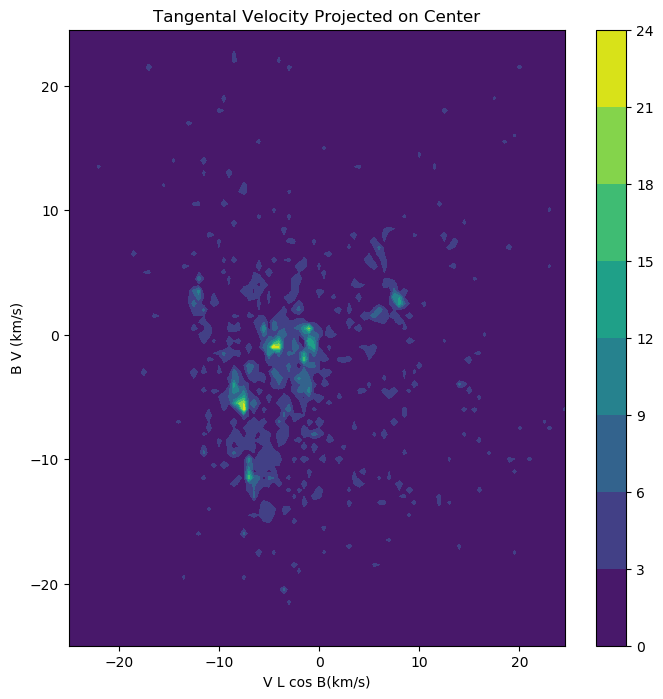

In [40]:
from matplotlib.colors import LogNorm
fig = plt.figure(figsize=(8,8))
ax = fig.subplots(1,1)
Z, xedges, yedges =np.histogram2d(sr_vl.value, sr_vb.value,bins=100,range = tv_zoom)

pcm = ax.contourf(xedges[:-1],yedges[:-1], Z.T)
#ax.contour(xedges[1:],yedges[1:], Z.T, colors='white')
#ax.scatter(km_vl.value, km_vb.value, s=20, color='red')


ax.set_xlabel('V L cos B(km/s)')
ax.set_ylabel('B V (km/s)')
ax.set_title('Tangental Velocity Projected on Center')
fig.colorbar(pcm)
#ax.set_xlim(-20,20)
#ax.set_ylim(-20,20)

Text(0.5, 1.0, 'Tangental Velocity Projected on Center')

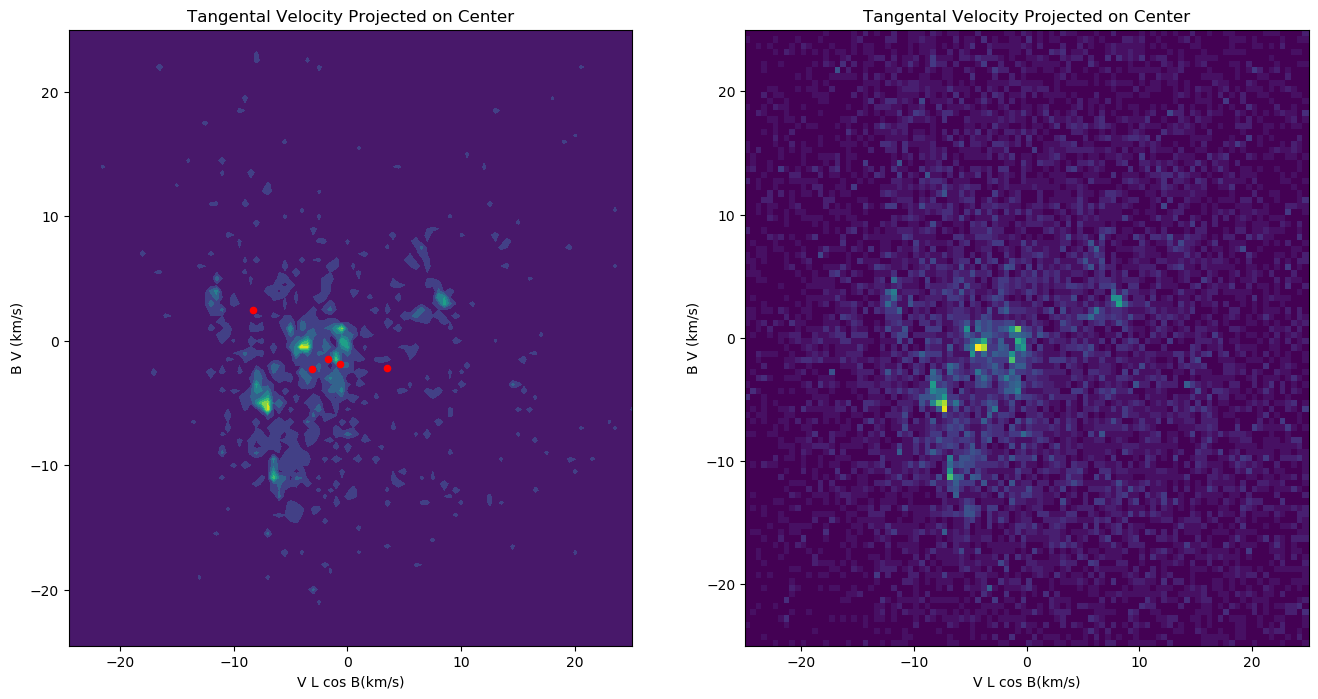

In [41]:
from matplotlib.colors import LogNorm
fig = plt.figure(figsize=(16,8))
axs = fig.subplots(1,2)
ax=axs[0]
Z, xedges, yedges =np.histogram2d(sr_vl.value, sr_vb.value,bins=100,range =tv_zoom)

pcm = ax.contourf(xedges[1:],yedges[1:], Z.T)
ax.scatter(km_vl.value, km_vb.value, s=20, color='red')


ax.set_xlabel('V L cos B(km/s)')
ax.set_ylabel('B V (km/s)')
ax.set_title('Tangental Velocity Projected on Center')

ax=axs[1]
ax.hist2d(sr_vl.value, sr_vb.value,bins=100,range = tv_zoom)
ax.set_xlabel('V L cos B(km/s)')
ax.set_ylabel('B V (km/s)')
ax.set_title('Tangental Velocity Projected on Center')

#fig.colorbar(pcm)
#ax.set_xlim(-20,20)
#ax.set_ylim(-20,20)

In [42]:
Z.shape, xedges.shape, yedges.shape

((100, 100), (101,), (101,))

In [43]:
sr_pos.value

array([[-119.32390084, -166.38921067, -219.30505435, ..., -156.19823924,
        -206.36520334, -132.81480834],
       [ -86.89557164, -121.32115256, -138.66718621, ...,  -88.31824615,
        -116.1869322 ,  -74.85577936],
       [ -70.53977679,  -97.88078047, -123.30530772, ..., -107.0541213 ,
        -141.09680465,  -91.56749751]])

In [44]:
tang_v_norm = zscore(np.array([sr_vl.value, sr_vb.value]), axis=1, ddof=1)
pos_norm = zscore(sr_pos.value, axis=1, ddof=1)

In [45]:
tang_v_norm

array([[ 1.23431769, -0.0424924 ,  0.25794379, ..., -0.39339814,
         0.08439158, -0.54914098],
       [ 0.25131816,  1.74483589, -0.78430938, ..., -0.38785763,
        -1.06185361, -0.50533769]])

In [46]:
tang_v_dbs = DBSCAN(eps=0.01, min_samples=10).fit(tang_v_norm.T)

In [47]:
tang_v_dbs.components_.shape

(364, 2)

In [48]:
labels, counts = np.unique(tang_v_dbs.labels_, return_counts=True)
labels, counts

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19]),
 array([18414,    46,    41,    89,    11,   108,    17,    11,    14,
           47,    22,    23,    14,    37,    44,    48,    10,    12,
           10,    10,    11]))

In [49]:
counts[1:].sum()

625

In [50]:
def gs_summarize(self, bycols, summarize_columns = ['ra','dec','parallax','r_est','pmra','pmdec', 'radial_velocity', 'vl','vb','tang_v']):
    means = self.objs.groupby(bycols)[summarize_columns].mean()
    stddevs = self.objs.groupby(bycols)[summarize_columns].std(ddof=1)
    stddevs.rename(columns = dict([(c,c+'_stddev') for c in summarize_columns]), inplace=True)
    n = self.objs.groupby(bycols)[summarize_columns].count()
    
    df = pd.concat([means, stddevs], axis=1)
    df['member_count'] = n.ra
    df['member_count_rv'] = n.radial_velocity

    return df

In [51]:
search_results.objs['ClusterID'] = tang_v_dbs.labels_
clusters = gs_summarize(search_results, 'ClusterID')

In [52]:
ic2118_members.objs['ClusterID'] = 1
ic2118 =gs(name = 'IC2118 Center', description='Summarized from IC2118 members')
ic2118.objs = gs_summarize(ic2118_members, 'ClusterID')
pm_to_tangv(ic2118,  search_center, default_rv=0)

(<Quantity [-2.46613529] km / s>,
 <Quantity [-0.85286982] km / s>,
 <Quantity [[-247.2249913 ],
            [-124.74216122],
            [-137.66603346]] pc>)

In [53]:
# get cluster means
search_results.objs['ClusterID'] = tang_v_dbs.labels_
clusters = gs_summarize(search_results, 'ClusterID')

cluster_gs = gs(name='consolidated dbscan results')
cluster_gs.objs = clusters
c_tv_l, c_tv_b, c_xyz = pm_to_tangv(cluster_gs, search_center, default_rv=0)
cluster_gs.objs['c_tv_l'] = c_tv_l.value; cluster_gs.objs['c_tv_b'] = c_tv_b.value

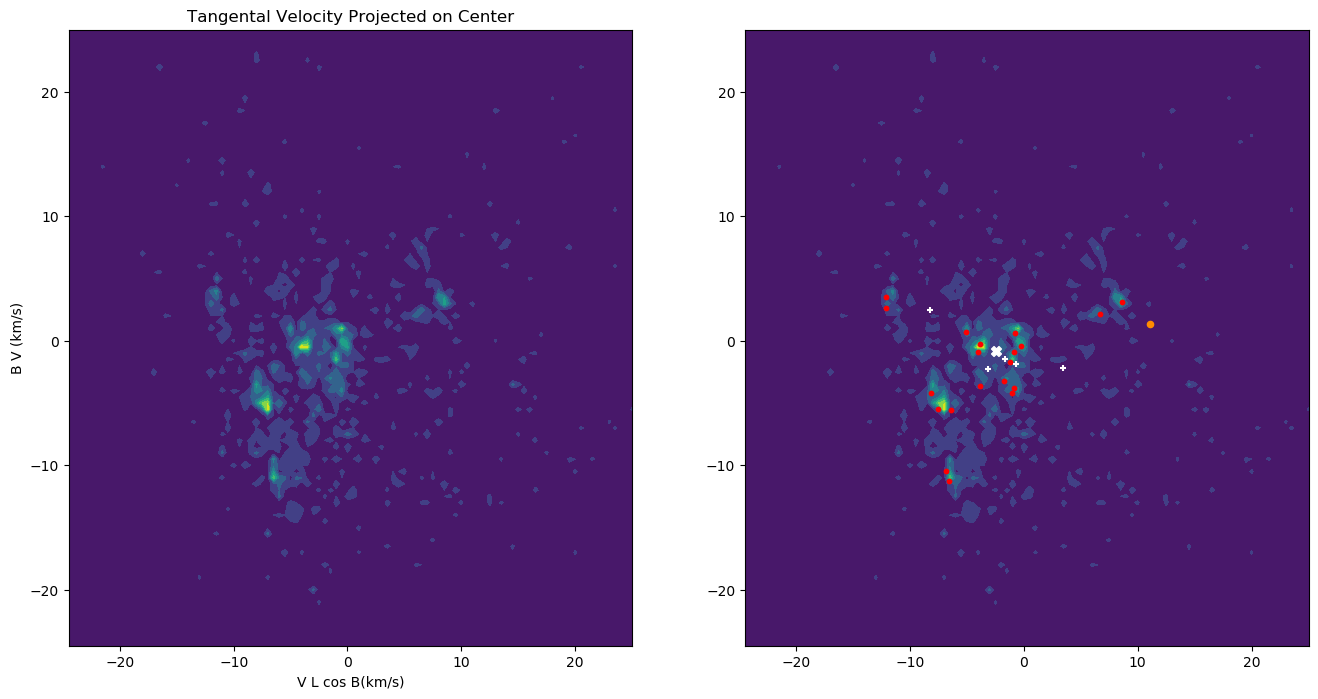

In [54]:
fig = plt.figure(figsize=(16,8))
axs = fig.subplots(1,2)
ax = axs[0]

Z, xedges, yedges =np.histogram2d(sr_vl.value, sr_vb.value,bins=100,range =tv_zoom)
pcm = ax.contourf(xedges[1:],yedges[1:], Z.T, cmap='viridis')

#ax.scatter(cluster_gs.objs.c_tv_l, cluster_gs.objs.c_tv_b,  color='red', s=10)
#ax.scatter(cluster_gs.objs.c_tv_l.loc[-1], cluster_gs.objs.c_tv_b.loc[-1], s=20, color='white')

ax.set_xlabel('V L cos B(km/s)')
ax.set_ylabel('B V (km/s)')
ax.set_title('Tangental Velocity Projected on Center')
#fig.colorbar(pcm)

ax = axs[1]
ic2118_tv_l, ic2118_tv_b, ic2118_xyz = pm_to_tangv(ic2118,  search_center, default_rv=0)


Z, xedges, yedges =np.histogram2d(sr_vl.value, sr_vb.value,bins=100,range =tv_zoom)
pcm = ax.contourf(xedges[1:],yedges[1:], Z.T, cmap='viridis')
ax.scatter(cluster_gs.objs.c_tv_l, cluster_gs.objs.c_tv_b,  color='red', s=10)
ax.scatter(cluster_gs.objs.c_tv_l.loc[-1], cluster_gs.objs.c_tv_b.loc[-1], s=20, color='darkorange')
ax.scatter(km_vl.value, km_vb.value, s=20, marker='+', color='white')
ax.scatter(ic2118_tv_l, ic2118_tv_b, s=50, color='white', marker='X')

In [55]:
#which cluster is closest to IC2118 in this space?
ic2118_tv_l, ic2118_tv_b, ic2118_xyz = pm_to_tangv(ic2118,  search_center, default_rv=0)
assert ic2118_tv_l.shape == (1,)
assert ic2118_tv_b.shape == (1,)
ic2118_tv_l = ic2118_tv_l[0]
ic2118_tv_b = ic2118_tv_b[0]
dist = np.sqrt((cluster_gs.objs.c_tv_l-ic2118_tv_l.value)**2 + (cluster_gs.objs.c_tv_b-ic2118_tv_b.value)**2)
closest_i = dist.argmin()
closest_lab = cluster_gs.objs.iloc[closest_i].name
print(f'Cluster label with  closest distance: {closest_lab}')
ic2118_candidates = search_results.query(f'ClusterID == {closest_lab}')

Cluster label with  closest distance: 10


In [56]:
cluster12 = search_results.query('ClusterID == 12')

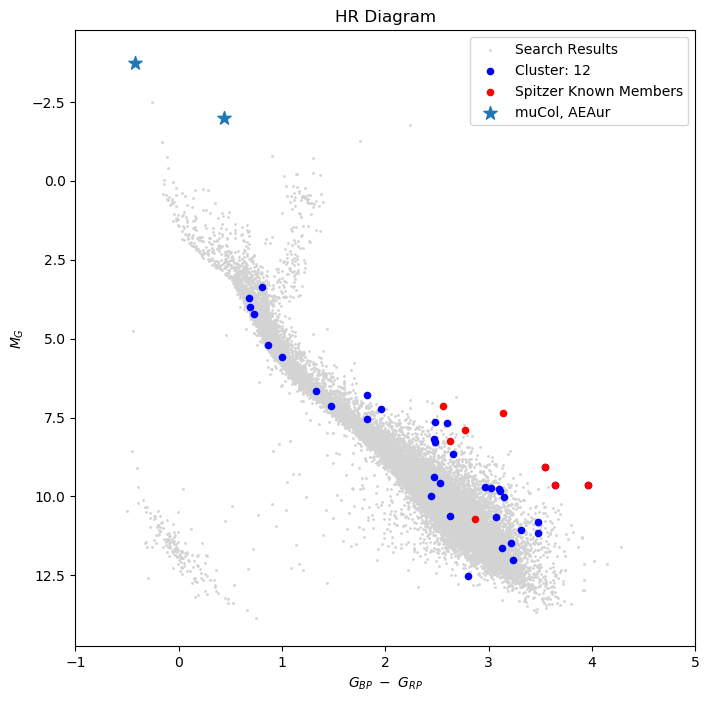

In [57]:
fig = plt.figure(figsize=(8,8))
ax = fig.subplots(1,1)

search_results.plot_hrdiagram(ax=ax, s=1, color='lightgrey', label='Search Results')
#ic2118_candidates.plot_hrdiagram(ax=ax, s=20, color='green', label='Cluster: 10')
cluster12.plot_hrdiagram(ax=ax, s=20, color='blue',label='Cluster: 12')
spitzer_members.plot_hrdiagram(ax=ax, color='red', s=20, label='Spitzer Known Members')
orion_runaways.plot_hrdiagram(ax=ax, s=100, marker='*', label='muCol, AEAur')

ax.legend()

In [58]:
search_results.objs.loc[list(set(spitzer_source_ids).intersection(set(search_results.objs.index)))].ClusterID

source_id
3211223665694190848    -1
3211223253378434560    12
3211222944140793984    -1
3211219576886431744    -1
3211219748685124352    12
3211220401520148992    12
Name: ClusterID, dtype: int64

In [59]:
search_results.objs.loc[list(set(ic2118_members_source_ids).intersection(set(search_results.objs.index)))].ClusterID

source_id
3183583970597624576   -1
3211222944140793984   -1
3211223665694190848   -1
Name: ClusterID, dtype: int64

(-25, 25)

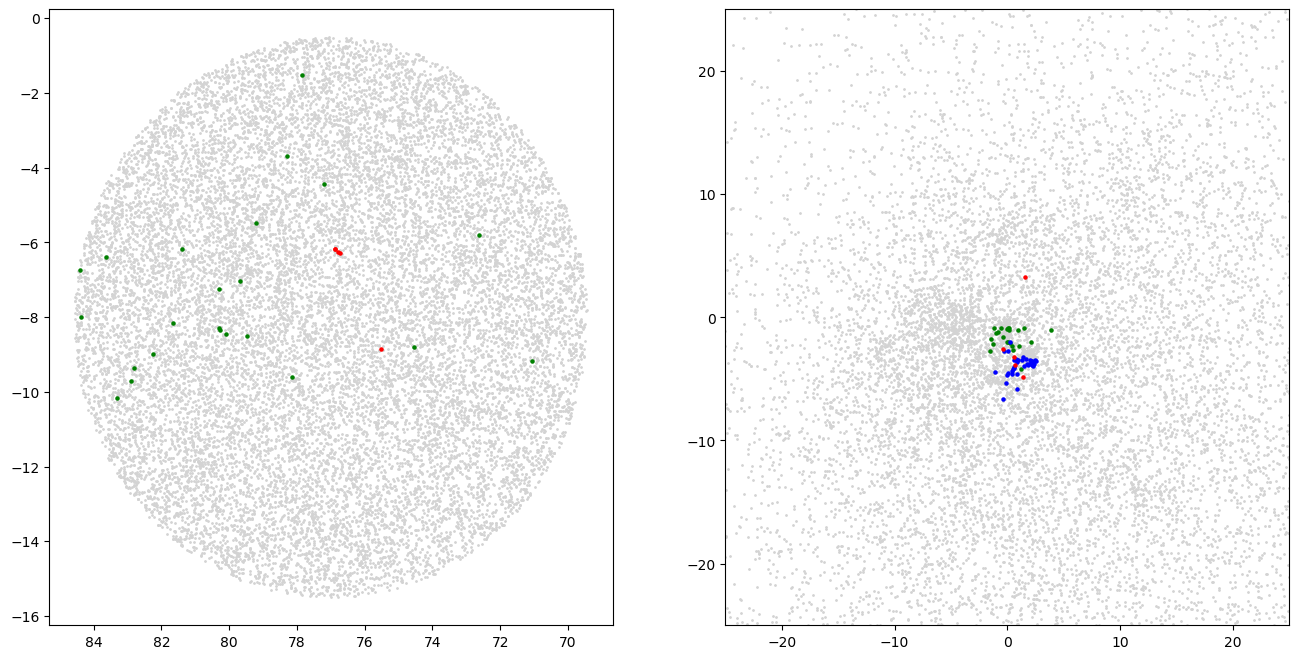

In [60]:


fig = plt.figure(figsize=(16,8))
axs = fig.subplots(1,2)
axs[0].scatter(search_results.objs.ra, search_results.objs.dec, s=1, color='lightgrey')
axs[0].scatter(ic2118_members.objs.ra, ic2118_members.objs.dec, s=5, color='red')
axs[0].scatter(ic2118_candidates.objs.ra, ic2118_candidates.objs.dec, s=5, color='green')
axs[0].invert_xaxis()

axs[1].scatter(search_results.objs.pmra, search_results.objs.pmdec, s=1, color='lightgrey')
axs[1].scatter(ic2118_candidates.objs.pmra, ic2118_candidates.objs.pmdec, s=5, color='green')
axs[1].scatter(cluster12.objs.pmra, cluster12.objs.pmdec, s=5, color='blue')
axs[1].scatter(ic2118_members.objs.pmra, ic2118_members.objs.pmdec, s=5, color='red')
axs[1].set_xlim(-25,25)
axs[1].set_ylim(-25,25)

In [61]:
star_labs, star_counts = np.unique(tang_v_dbs.labels_, return_counts=True)
valid_labs = star_labs[np.flip(star_counts.argsort())[0:10]]
valid_labs = valid_labs[valid_labs != -1]
all_labs = np.array( ['Cluster_'+str(cl) for cl in tang_v_dbs.labels_])
is_valid = np.array([l in valid_labs for l in tang_v_dbs.labels_])
all_labs = np.where(is_valid, all_labs, 'Background')
search_results.objs['Cluster_label'] = all_labs

In [62]:
np.unique(all_labs, return_counts=True)

(array(['Background', 'Cluster_0', 'Cluster_1', 'Cluster_10', 'Cluster_12',
        'Cluster_13', 'Cluster_14', 'Cluster_2', 'Cluster_4', 'Cluster_8'],
       dtype='<U10'),
 array([18556,    46,    41,    23,    37,    44,    48,    89,   108,
           47]))

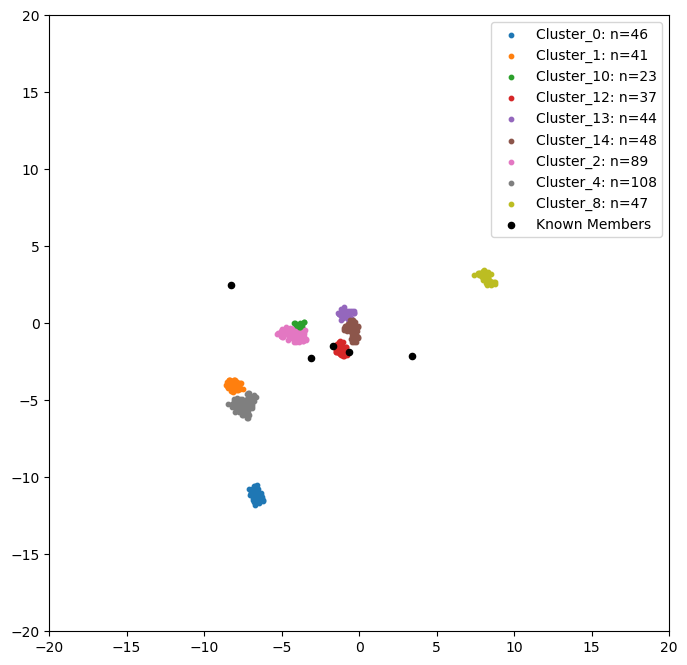

In [63]:
import seaborn as sns
#sns.set_theme()
tangv_label = pd.DataFrame({'sr_vl':sr_vl.value, 'sr_vb':sr_vb.value, 
                            'label':all_labs  })
#tangv_label['Group'] = np.where(tang_v_dbs.labels_ == 1, 'Main Group', 'Background')

fig = plt.figure(figsize=(8,8))
ax = fig.subplots(1,1)
#.query('label != \'Background\' and label != \'Cluster_0\'')
#sns.scatterplot(data=tangv_label,x='sr_vl', y='sr_vb', hue='label', s=2)

for l in np.unique(all_labs):
    if l=='Background':
        continue
    xx = tangv_label.query('label == @l')
    ax.scatter(xx.sr_vl, xx.sr_vb, s=10, label=f'{l}: n={len(xx)}', alpha=0.5 if l=='Background' else 1)
    
ax.scatter(km_vl.value, km_vb.value, s=20, color='black',edgecolor='black',label='Known Members')
ax.set_xlim(-20,20)
ax.set_ylim(-20,20)
ax.legend()

In [64]:
len(all_labs)

19039

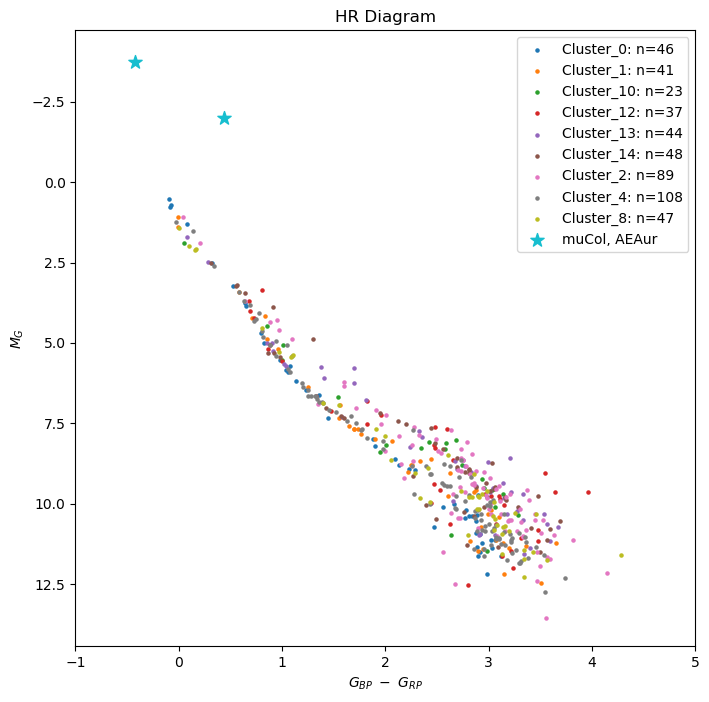

In [65]:
fig = plt.figure(figsize=(8,8))
ax = fig.subplots(1,1)

for l in np.unique(all_labs):
    if l=='Background':
        continue
    xx = search_results.query(f'Cluster_label == \'{l}\'')
    xx.plot_hrdiagram(ax=ax,s=5, label=f'{l}: n={len(xx)}')
orion_runaways.plot_hrdiagram(ax=ax, s=100, marker='*', label='muCol, AEAur')
ax.legend()

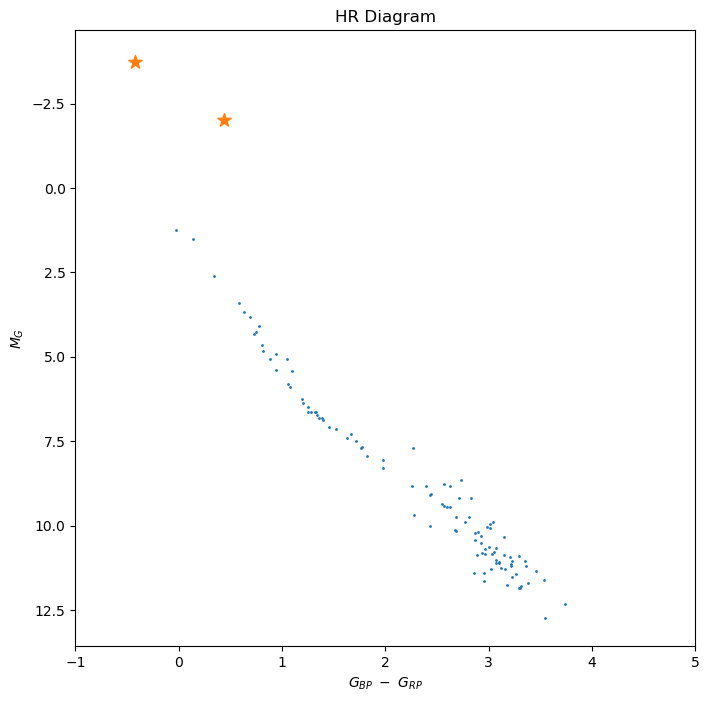

In [66]:
fig = plt.figure(figsize=(8,8))
ax = fig.subplots(1,1)
search_results.query('ClusterID == 4').plot_hrdiagram(ax=ax)
orion_runaways.plot_hrdiagram(ax=ax, s=100, marker='*', label='muCol, AEAur')

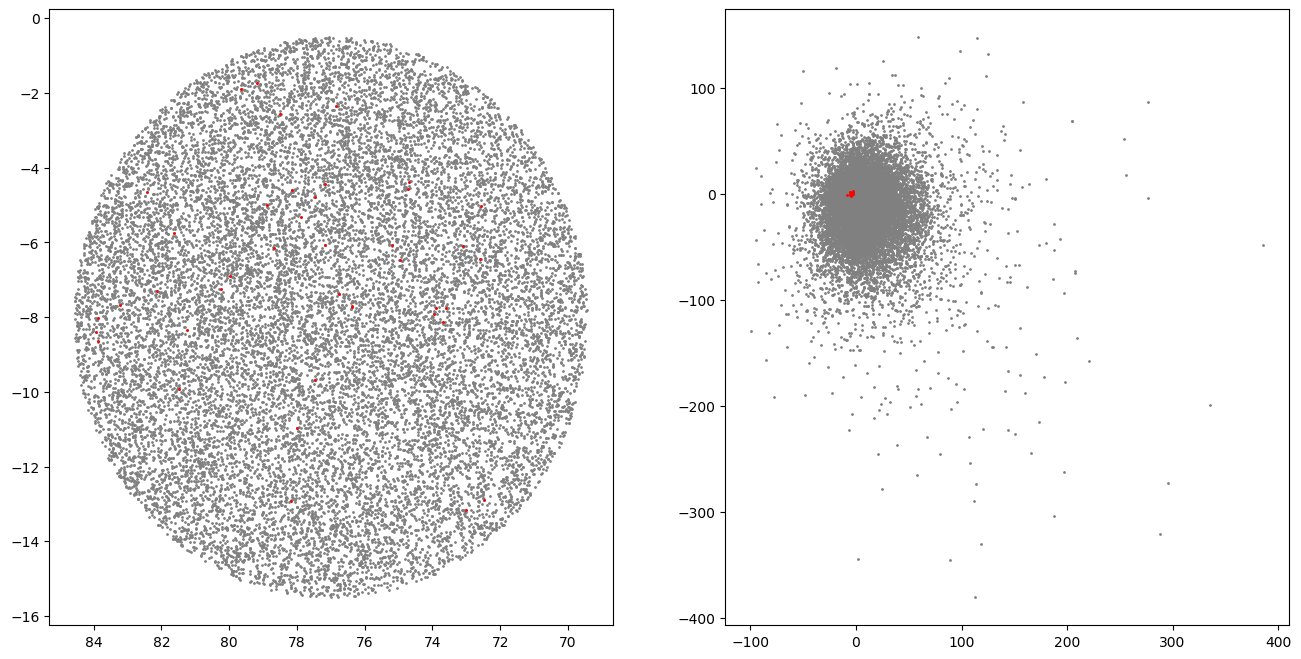

In [67]:
clust1=search_results.query('ClusterID == 1')

fig = plt.figure(figsize=(16,8))
axs = fig.subplots(1,2)
axs[0].scatter(search_results.objs.ra, search_results.objs.dec, s=1, color='grey')
axs[0].scatter(clust1.objs.ra, clust1.objs.dec, s=1, color='red')
axs[0].invert_xaxis()

axs[1].scatter(search_results.objs.pmra, search_results.objs.pmdec, s=1, color='grey')
axs[1].scatter(clust1.objs.pmra, clust1.objs.pmdec, s=1, color='red')

## Clustering on Position

In [68]:
pos_dbs = DBSCAN(eps=0.05, min_samples=8).fit(pos_norm.T)

In [69]:
np.unique(pos_dbs.labels_, return_counts=True)

(array([-1,  0]), array([19031,     8]))

In [70]:
tang_v_pos_norm = np.vstack([tang_v_norm, pos_norm])
tang_v_pos_dbs = DBSCAN(eps=0.01, min_samples=10).fit(tang_v_pos_norm.T)

In [71]:
np.unique(tang_v_pos_dbs.labels_, return_counts=True)

(array([-1]), array([19039]))

## Velocity Dispersion Within Clusters

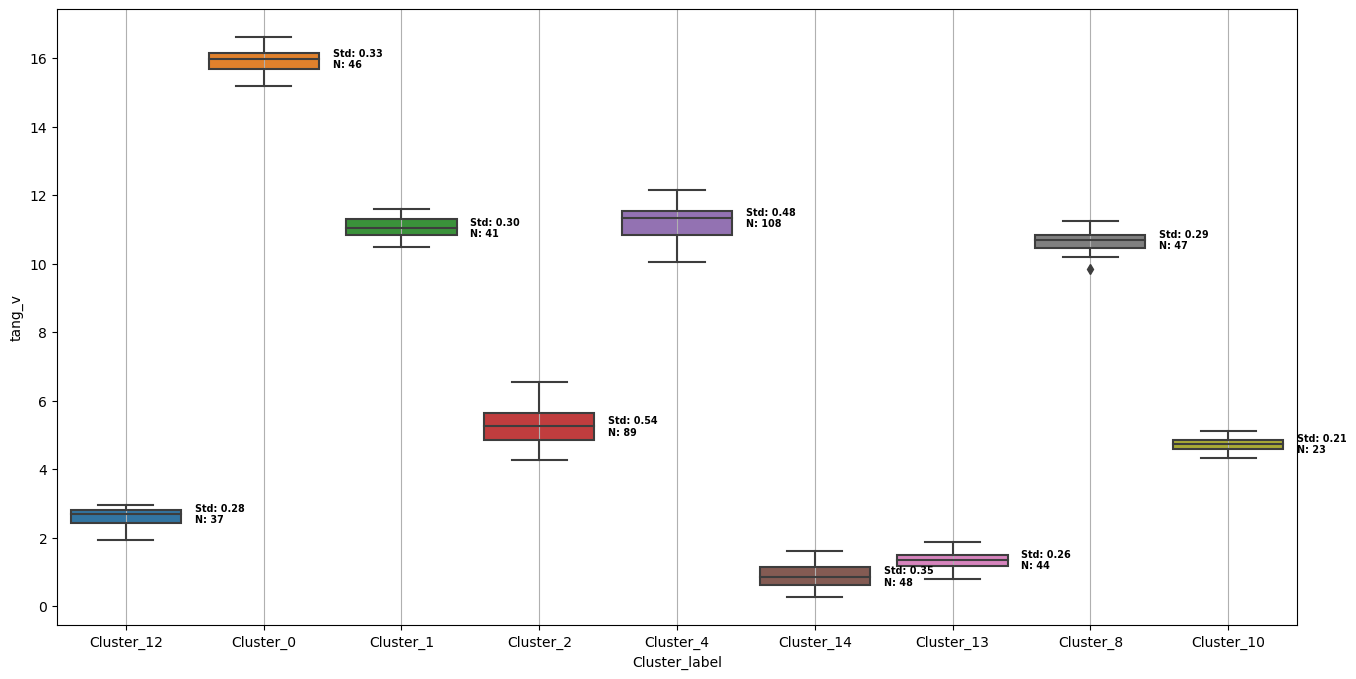

In [72]:
nbkgrnd = search_results.objs.query('Cluster_label != \'Background\'')
meds = nbkgrnd.groupby('Cluster_label')['tang_v'].median()
stds = nbkgrnd.groupby('Cluster_label')['tang_v'].std(ddof=1)
members = nbkgrnd.groupby('Cluster_label')['tang_v'].count()


fig = plt.figure(figsize=(16,8))
ax = fig.subplots(1,1)
box_plot = sns.boxplot(data=nbkgrnd, x='Cluster_label', y='tang_v', ax=ax)

for xtick, lab in enumerate(box_plot.get_xticklabels()):
    l = lab.get_text()
    box_plot.text(xtick+0.5, meds.loc[l], f'Std: {stds.loc[l]:.2f}\nN: {members.loc[l]}',
                 horizontalalignment='left',va='center',size='x-small',color='black',weight='semibold')


#sns.swarmplot(x='Cluster_label', y='tang_v', data=nbkgrnd, color='black', alpha=0.4,ax=ax)
ax.grid(axis='x')

In [73]:
lab.get_text()

'Cluster_10'

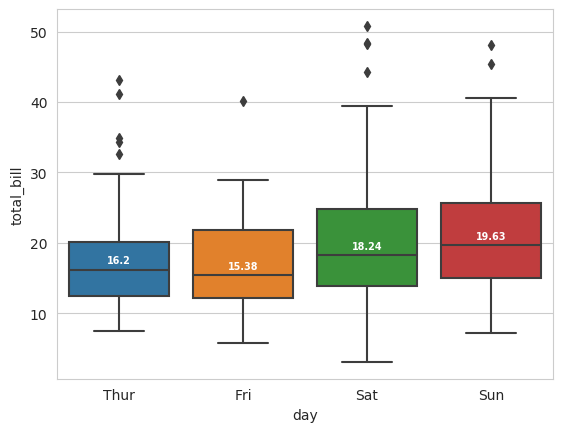

In [74]:
import seaborn as sns

sns.set_style("whitegrid")
tips = sns.load_dataset("tips")
box_plot = sns.boxplot(x="day",y="total_bill",data=tips)

medians = tips.groupby(['day'])['total_bill'].median()
vertical_offset = tips['total_bill'].median() * 0.05 # offset from median for display

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')

In [75]:
medians[0]

16.2

In [76]:
cl12_gal = search_results.query('Cluster_label == \'Cluster_12\'').get_coords(recalc=True, default_rv=True)

In [77]:
cl12_gal.galacticlsr

<SkyCoord (GalacticLSR: v_bary=(11.1, 12.24, 7.25) km / s): (l, b, distance) in (deg, deg, pc)
    [(212.09694354, -26.16925854, 207.14250873),
     (211.86704837, -26.35085879, 194.72983892),
     (213.69562429, -27.44109949, 272.73498767),
     (213.43784767, -25.20074116, 216.59043025),
     (211.32157118, -23.95893814, 294.54724004),
     (212.04481343, -22.84116061, 175.1837584 ),
     (203.2854255 , -31.6241901 , 247.86730926),
     (209.72173362, -23.68530021, 157.57152752),
     (206.43874259, -25.97252961, 296.24593951),
     (206.4266873 , -25.90579566, 286.27192894),
     (206.41010074, -25.9217054 , 287.08011819),
     (205.24446561, -21.98956577, 230.12853405),
     (204.39919213, -23.82921889, 282.26286979),
     (204.47007552, -22.71612795, 282.21774986),
     (205.04658767, -25.56264849, 273.42518826),
     (204.98090372, -25.50850847, 271.39455501),
     (203.7184415 , -22.59824946, 286.39142902),
     (203.71132554, -22.59818392, 287.80147125),
     (203.14756212, -24

In [78]:
search_results.objs.columns

Index(['ra', 'dec', 'parallax', 'pmra', 'pmdec', 'radial_velocity',
       'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'ruwe',
       'r_est', 'hasRV', 'vl', 'vb', 'tang_v', 'ClusterID', 'Cluster_label'],
      dtype='object')

In [79]:
ic2118_members_vl, ic2118_members_vb, ic2118_members_xyz = pm_to_tangv(ic2118_members,  search_center, default_rv=0)
#normalize using params from search results
ic2118_members_v_norm = np.array([(ic2118_members_vl - sr_vl.mean())/sr_vl.std(ddof=1),
                                  (ic2118_members_vb - sr_vb.mean())/sr_vb.std(ddof=1)])

In [80]:
ic2118_members_v_norm

array([[-0.61549289, -0.21235861, -0.35325605, -0.38808099, -0.43818451],
       [ 0.05936549, -0.13533109, -0.12296755, -0.10696032, -0.13877542]])

In [81]:
def dbscan_predict(model, X):

    nr_samples = X.shape[0]

    y_new = np.ones(shape=nr_samples, dtype=int) * -1

    for i in range(nr_samples):
        diff = model.components_ - X[i, :]  # NumPy broadcasting

        dist = np.linalg.norm(diff, axis=1)  # Euclidean distance

        shortest_dist_idx = np.argmin(dist)

        if dist[shortest_dist_idx] < model.eps:
            y_new[i] = model.labels_[model.core_sample_indices_[shortest_dist_idx]]

    return y_new

In [82]:
dbscan_predict(tang_v_dbs,ic2118_members_v_norm.T)

array([-1, -1, -1, -1, -1])

In [83]:
tang_v_dbs.components_.shape

(364, 2)

## Gaussian Mixture

In [90]:
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture

In [92]:
gmm =  GaussianMixture(n_components = 50, random_state=1234,verbose=1, max_iter=500)
gmm.fit(tang_v_norm.T)

Initialization 0
Initialization converged: True


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=500,
                means_init=None, n_components=50, n_init=1,
                precisions_init=None, random_state=1234, reg_covar=1e-06,
                tol=0.001, verbose=1, verbose_interval=10, warm_start=False,
                weights_init=None)

In [93]:
gmm_labs = gmm.predict(tang_v_norm.T)

In [94]:
np.unique(gmm_labs, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 array([   1, 1460,  151,  105,  778,  292,  851,  211,    9,  154,  331,
          36,  618,  475,    5,  193,  444,  330,   18,  393,   64,   32,
         239,   20,   64,  216,  480,  128,  974, 1009,   45,  721, 1033,
         395,  300,  756,   51,   25,  210,  379,  226,  799,   25,  473,
         418,  646,  246,  652, 1511,   47]))

In [96]:
km_vl, km_vb, km_pos = pm_to_tangv(ic2118_members, search_center, 0.0)
km_tang_v_norm = zscore(np.array([km_vl, km_vb]), axis=1, ddof=1)

In [97]:
km_tang_v_norm.shape

(2, 5)

In [98]:
gmm.predict(km_tang_v_norm.T)

array([46,  4, 29, 29, 28])

In [99]:
sp_vl, sp_vb, sp_pos = pm_to_tangv(spitzer_members, search_center, 0.0)
sp_tang_v_norm = zscore(np.array([sp_vl, sp_vb]), axis=1, ddof=1)

/home/kevin_leo_mcmanus/anaconda3/envs/astro/lib/python3.7/site-packages/astropy/coordinates/angles.py:522: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/home/kevin_leo_mcmanus/anaconda3/envs/astro/lib/python3.7/site-packages/astropy/coordinates/angles.py:522: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):


In [100]:
sp_tang_v_norm

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan]])